In [1]:
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
import os, getpass

def _set_env(var: str):

    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")

    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ToDo_Agents"

LANGCHAIN_API_KEY: ··········


In [3]:
_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [4]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [5]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):

        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )


spy = Spy()

model = ChatOpenAI(model="gpt-4o", temperature=0)


trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)


trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

instruction = """Extract memories from the following conversation:"""


conversation = [HumanMessage(content="Hi, I'm Tharun."),
                AIMessage(content="Nice to meet you, Tharun."),
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]


result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [7]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_uzfmdS2u4vzu2osPi2CwRNNi)
 Call ID: call_uzfmdS2u4vzu2osPi2CwRNNi
  Args:
    content: Tharun had a nice bike ride in San Francisco this morning.


In [8]:
for m in result["responses"]:
    print(m)

content='Tharun had a nice bike ride in San Francisco this morning.'


In [9]:
 for m in result["response_metadata"]:
    print(m)

{'id': 'call_uzfmdS2u4vzu2osPi2CwRNNi'}


In [10]:

updated_conversation = [AIMessage(content="That's great, did you do after?"),
                        HumanMessage(content="I went to Tartine and ate a croissant."),
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]


system_msg = """Update existing memories and create new ones based on the following conversation:"""

tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Tharun had a nice bike ride in San Francisco this morning.'})]

In [11]:

result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation,
                                                        "existing": existing_memories})

In [12]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_LE3Ow7fRrXeeTzzUEZh7Xg5l', 'json_doc_id': '0'}
{'id': 'call_8ztnU7cylCvaYTJRpCEt5C2g'}


In [13]:

for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_LE3Ow7fRrXeeTzzUEZh7Xg5l)
 Call ID: call_LE3Ow7fRrXeeTzzUEZh7Xg5l
  Args:
    content: Tharun had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.
  Memory (call_8ztnU7cylCvaYTJRpCEt5C2g)
 Call ID: call_8ztnU7cylCvaYTJRpCEt5C2g
  Args:
    content: Tharun went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.


In [14]:
for m in result["responses"]:
    print(m)

content='Tharun had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'
content='Tharun went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'


In [15]:
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': '1. Replace the existing memory content with the updated memory that includes the new activities: going to Tartine and eating a croissant, and thinking about going back to Japan this winter.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Tharun had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'}]},
   'id': 'call_LE3Ow7fRrXeeTzzUEZh7Xg5l',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'Tharun went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'},
   'id': 'call_8ztnU7cylCvaYTJRpCEt5C2g',
   'type': 'tool_call'}]]

In [16]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.

    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []

    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )

    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: 1. Replace the existing memory content with the updated memory that includes the new activities: going to Tartine and eating a croissant, and thinking about going back to Japan this winter.
Added content: Tharun had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.

New Memory created:
Content: {'content': 'Tharun went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'}


In [17]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

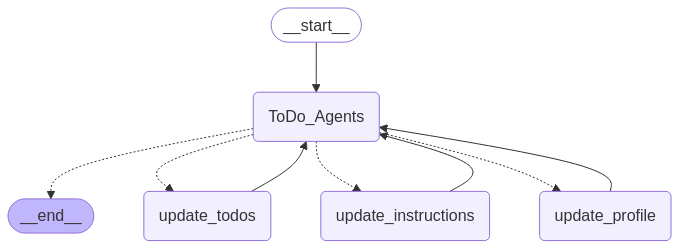

In [32]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_core.runnables.graph_mermaid import draw_mermaid_png, MermaidDrawMethod
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has",
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )


profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)


MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot.

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them)
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below.

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction.

Use the provided tools to retain any necessary memories about the user.

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items.

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def ToDo_Agents(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""

    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages,
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()

    # Create the Trustcall extractor for updating the ToDo list
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages,
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")

    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)


builder.add_node(ToDo_Agents)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "ToDo_Agents")
builder.add_conditional_edges("ToDo_Agents", route_message)
builder.add_edge("update_todos", "ToDo_Agents")
builder.add_edge("update_profile", "ToDo_Agents")
builder.add_edge("update_instructions", "ToDo_Agents")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()


within_thread_memory = MemorySaver()


graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [20]:

config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Tharun. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Tharun. I live in SF with my wife. I have a 1 year old daughter.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JmU4Dg2Kk5nrPfIPJBP5XeSk)
 Call ID: call_JmU4Dg2Kk5nrPfIPJBP5XeSk
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it! If there's anything else you'd like to share or need help with, just let me know.


In [21]:
# User input for a ToDo
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_iRBGxpP5vtyxCIvXqjF2vm0Z)
 Call ID: call_iRBGxpP5vtyxCIvXqjF2vm0Z
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'solutions': ['Check local swim schools in SF', 'Look for baby swim classes online', 'Ask friends for recommendations'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Book swim lessons for the baby" to your ToDo list. If you need any help with this task, feel free to ask!


In [22]:

input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_BdIU2qvyELE1lCI9SNu9RwAA)
 Call ID: call_BdIU2qvyELE1lCI9SNu9RwAA
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to include specific local businesses or vendors when creating or updating your ToDo items. If there's anything else you need, just let me know!


In [23]:
# Check for updated instructions
user_id = "Tharun"


for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

In [24]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_i3uCTy7WoFr6iVJUyJoXZ7xw)
 Call ID: call_i3uCTy7WoFr6iVJUyJoXZ7xw
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Fix the jammed electric Yale lock on the door.', 'time_to_complete': 60, 'solutions': ['Contact a local locksmith in SF', "Check Yale's customer support for troubleshooting", 'Look for online tutorials specific to Yale locks'], 'status': 'not started'}

Document 1957aea1-d8ec-4024-8a67-6617abc8493a updated:
Plan: Add specific local businesses or vendors to the solutions for booking swim lessons.
Added content: ['Check local swim schools in SF like La Petite Baleen or Pomeroy Recreation & Rehabilitation Pool', 'Look for baby sw

In [25]:
# Namespace for the memory to save
user_id = "Tharun"

# Search
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

In [26]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_Qt0Bg9tiVP93rysEAocF8gAo)
 Call ID: call_Qt0Bg9tiVP93rysEAocF8gAo
  Args:
    update_type: todo
================================= Tool Message =================================

Document 1957aea1-d8ec-4024-8a67-6617abc8493a updated:
Plan: Add a deadline for the task to be completed by the end of November.
Added content: 2025-11-30T23:59:59
================================== Ai Message ==================================

I've updated the deadline for booking swim lessons for the baby to the end of November. If there's anything else you need, just let me know!


In [27]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_4evtVnNlSbJxH30cyRns68gr)
 Call ID: call_4evtVnNlSbJxH30cyRns68gr
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call back City Toyota to schedule car service.', 'time_to_complete': 15, 'solutions': ['Find the contact number for City Toyota', 'Check available service slots', 'Prepare car details for the service'], 'status': 'not started'}

Document 34262682-1c90-4454-bec0-ec740632444c updated:
Plan: Add specific local businesses or vendors to the solutions for fixing the jammed electric Yale lock.
Added content: ['Contact a local locksmith in SF like "Lock World" or "The Flying Locksmiths"', "Check Yale's customer support for troubleshooti

In [28]:
# Namespace for the memory to save
user_id = "Tharun"

# Search
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

In [29]:

config = {"configurable": {"thread_id": "2", "user_id": "Tharun"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

It looks like your ToDo list is currently empty, so I don't have any tasks to suggest. If you have any tasks in mind, feel free to share them with me, and I can help you keep track of them!


In [30]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_aqcUPuc1yrNBNGPuAptennbX)
 Call ID: call_aqcUPuc1yrNBNGPuAptennbX
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Find options to call for swim lessons', 'time_to_complete': 30, 'solutions': ['Local community center', 'YMCA', 'Private swim schools', 'Local gyms with pools', 'Online platforms like Swimply'], 'status': 'not started'}
================================== Ai Message ==================================

I've added a task to your ToDo list to find options for swim lessons. Here are some places you can consider calling:

1. Local community center
2. YMCA
3. Private swim schools
4. Local gyms with pools
5. Online platforms like Swimply

